# Hierarchical Clustering on Grafana Logs

This notebook applies Hierarchical (Agglomerative) clustering to Grafana logs.

## Steps:
1. Load feature matrix
2. Create dendrogram to visualize hierarchy
3. Determine optimal number of clusters
4. Apply Agglomerative clustering
5. Evaluate clustering quality
6. Visualize clusters
7. Analyze cluster characteristics
8. Benchmark performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load feature matrix (scaled version)
X = pd.read_csv('../data/feature_matrix_scaled.csv')
metadata = pd.read_csv('../data/metadata.csv')

print(f"Feature matrix shape: {X.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nAnomaly distribution:")
print(metadata['is_anomaly'].value_counts())

Feature matrix shape: (149999, 45)
Metadata shape: (149999, 6)

Anomaly distribution:
is_anomaly
False    119999
True      30000
Name: count, dtype: int64


## 2. Create Dendrogram (on sample)

Due to computational constraints, we'll use a sample for dendrogram visualization.

Creating dendrogram with 1000 samples...
Computing linkage: ward...
Computing linkage: complete...
Computing linkage: average...
Computing linkage: single...


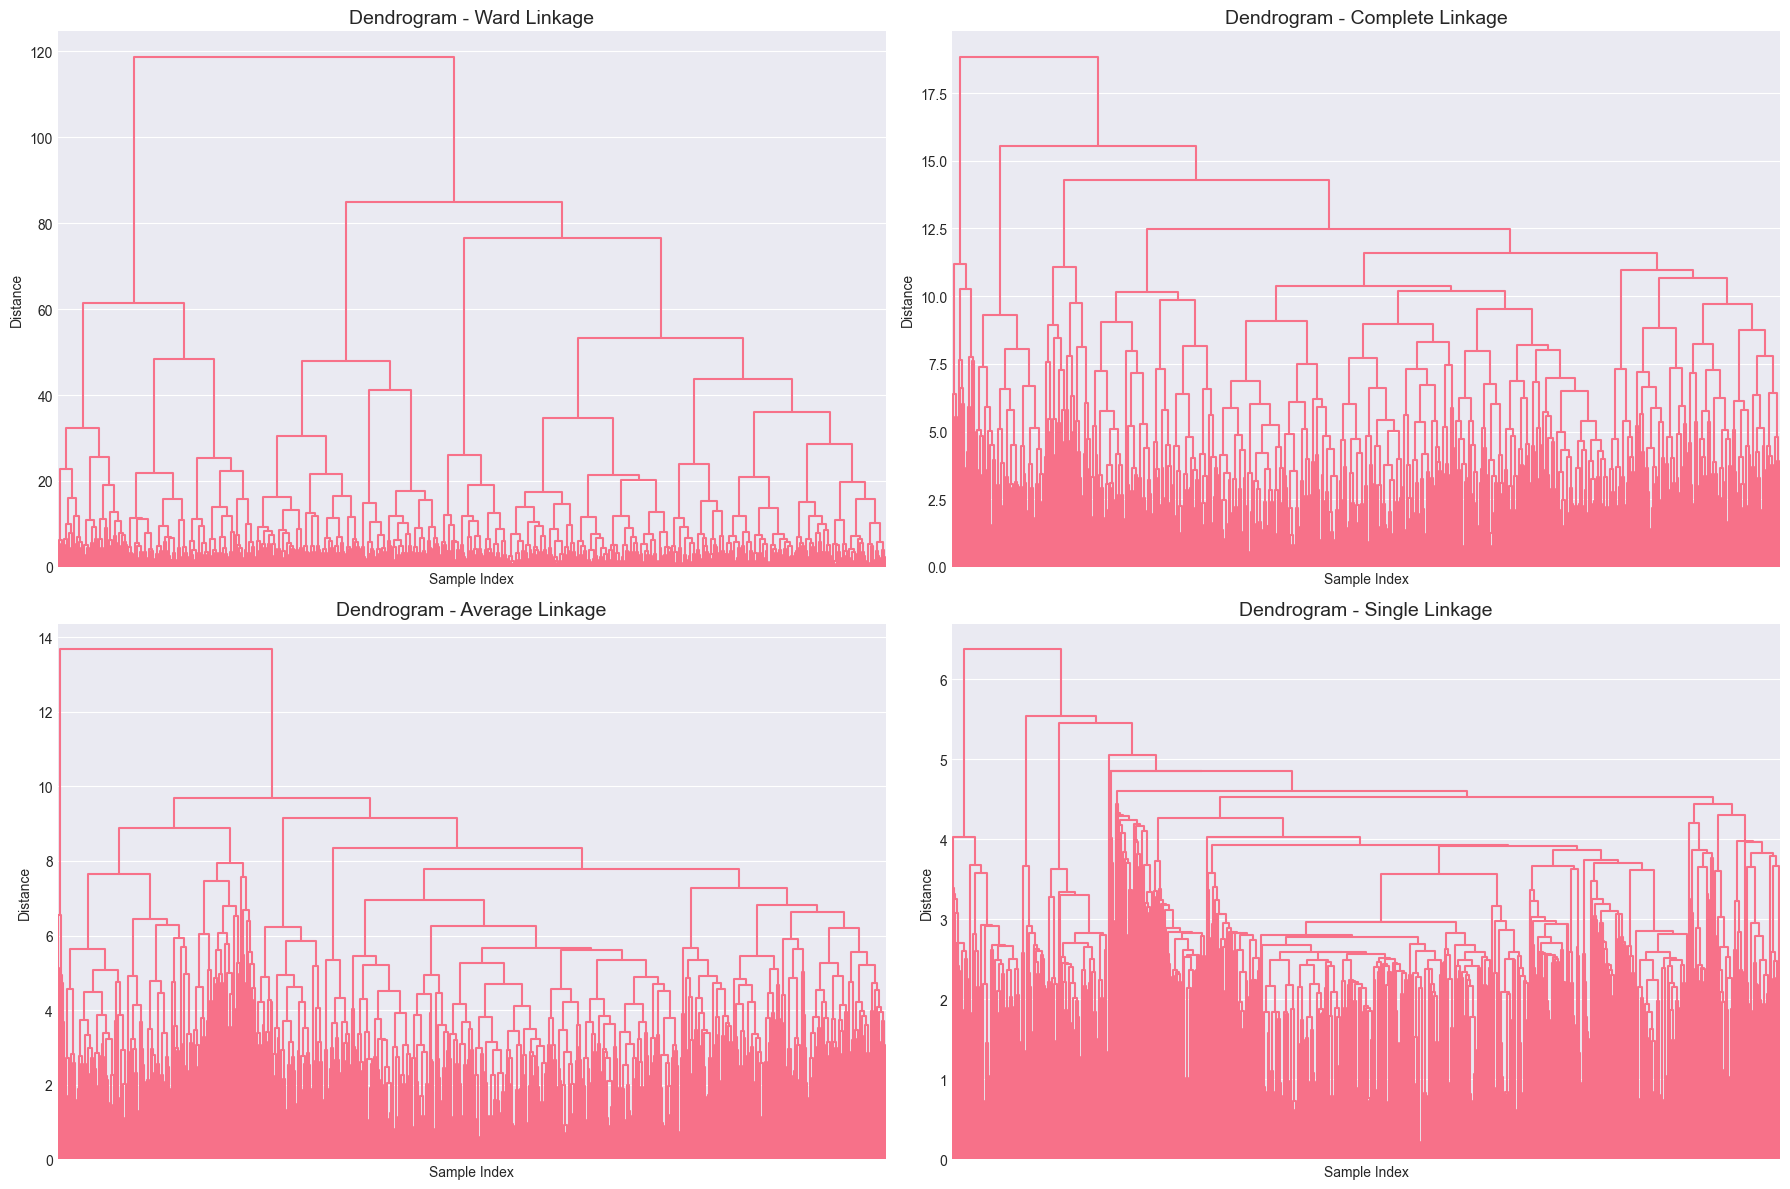

Dendrograms created!


In [3]:
# Sample data for dendrogram (hierarchical clustering on full data is memory intensive)
sample_size = min(1000, len(X))
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_indices]

print(f"Creating dendrogram with {sample_size} samples...")

# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for idx, method in enumerate(linkage_methods):
    print(f"Computing linkage: {method}...")
    Z = linkage(X_sample, method=method)
    
    dendrogram(Z, ax=axes[idx], no_labels=True, color_threshold=0)
    axes[idx].set_title(f'Dendrogram - {method.capitalize()} Linkage', fontsize=14)
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Distance')

plt.tight_layout()
plt.show()

print("Dendrograms created!")

## 3. Determine Optimal Number of Clusters

Test different linkage methods and cluster counts.

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# PCA (auto-safe)
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X)

k_range = range(2, 11)

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Testing different numbers of clusters (fast)...")

for k in k_range:
    print(f"Testing k={k}...", end=' ')
    
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        n_init=5,
        random_state=42
    )
    
    labels = kmeans.fit_predict(X_reduced)

    silhouette_scores.append(
        silhouette_score(X_reduced, labels, sample_size=5000)
    )
    davies_bouldin_scores.append(
        davies_bouldin_score(X_reduced, labels)
    )
    calinski_harabasz_scores.append(
        calinski_harabasz_score(X_reduced, labels)
    )

    print(f"Silhouette: {silhouette_scores[-1]:.3f}")

print("\nOptimization complete!")


Testing different numbers of clusters (fast)...
Testing k=2... Silhouette: 0.171
Testing k=3... Silhouette: 0.182
Testing k=4... Silhouette: 0.192
Testing k=5... Silhouette: 0.217
Testing k=6... Silhouette: 0.210
Testing k=7... Silhouette: 0.206
Testing k=8... Silhouette: 0.231
Testing k=9... Silhouette: 0.199
Testing k=10... Silhouette: 0.193

Optimization complete!


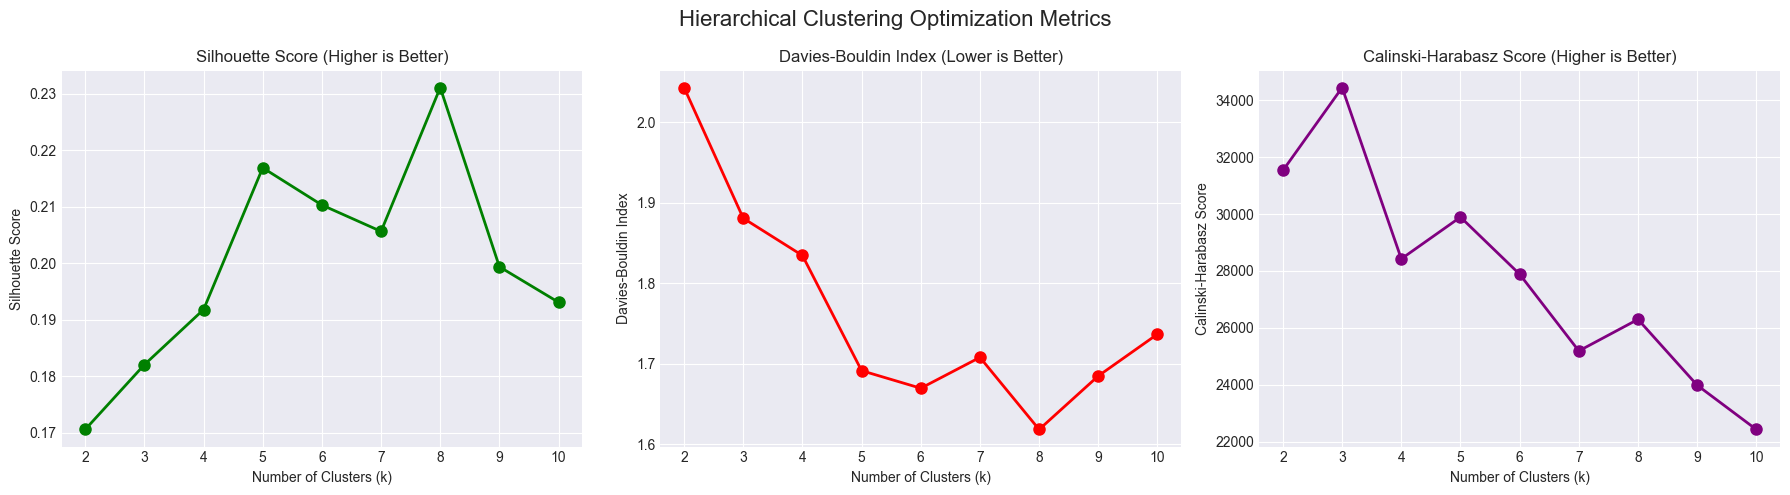


Optimal k based on:
  - Silhouette Score: 8
  - Davies-Bouldin Index: 8
  - Calinski-Harabasz Score: 3


In [7]:
# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Hierarchical Clustering Optimization Metrics', fontsize=16)

# Silhouette score
axes[0].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score (Higher is Better)')
axes[0].grid(True)

# Davies-Bouldin Index
axes[1].plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color='red')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1].grid(True)

# Calinski-Harabasz Index
axes[2].plot(k_range, calinski_harabasz_scores, marker='o', linewidth=2, markersize=8, color='purple')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print(f"\nOptimal k based on:")
print(f"  - Silhouette Score: {optimal_k_silhouette}")
print(f"  - Davies-Bouldin Index: {optimal_k_db}")
print(f"  - Calinski-Harabasz Score: {optimal_k_ch}")

## 4. Apply Hierarchical Clustering with Optimal Clusters

In [10]:
# # Use the k with best silhouette score
# optimal_k = optimal_k_silhouette
# print(f"Using k={optimal_k} clusters with {linkage_method} linkage")

# # Benchmark Hierarchical clustering performance
# start_time = time.time()

# agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage=linkage_method)
# cluster_labels = agg_final.fit_predict(X)

# training_time = time.time() - start_time

# print(f"\nHierarchical clustering completed in {training_time:.2f} seconds")
# print(f"Cluster distribution:")
# print(pd.Series(cluster_labels).value_counts().sort_index())
import numpy as np
import pandas as pd
import time
from sklearn.cluster import AgglomerativeClustering

# Use the k with best silhouette score
optimal_k = optimal_k_silhouette
print(f"Using k={optimal_k} clusters with {linkage_method} linkage")

# --------------------------------------------
# Sample rows correctly using .iloc
# --------------------------------------------
sample_size = 5000
np.random.seed(42)

sample_indices = np.random.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_indices]   # ✅ FIX

# Benchmark Hierarchical clustering performance
start_time = time.time()

agg_final = AgglomerativeClustering(
    n_clusters=optimal_k,
    linkage=linkage_method
)

cluster_labels_sample = agg_final.fit_predict(X_sample)

training_time = time.time() - start_time

print(f"\nHierarchical clustering (sample-based) completed in {training_time:.2f} seconds")
print("Cluster distribution (sample):")
print(pd.Series(cluster_labels_sample).value_counts().sort_index())


Using k=8 clusters with ward linkage

Hierarchical clustering (sample-based) completed in 2.01 seconds
Cluster distribution (sample):
0    1046
1    1128
2     847
3     380
4     349
5     464
6     431
7     355
Name: count, dtype: int64


## 5. Evaluate Clustering Quality

In [13]:
# # Calculate metrics
# silhouette_avg = silhouette_score(X, cluster_labels)
# davies_bouldin = davies_bouldin_score(X, cluster_labels)
# calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

# print("="*80)
# print("HIERARCHICAL CLUSTERING EVALUATION METRICS")
# print("="*80)
# print(f"Number of clusters: {optimal_k}")
# print(f"Linkage method: {linkage_method}")
# print(f"Training time: {training_time:.2f} seconds")
# print(f"\nInternal Validation Metrics:")
# print(f"  - Silhouette Score: {silhouette_avg:.4f} (range: [-1, 1], higher is better)")
# print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
# print(f"  - Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")

# # External validation (if true labels available)
# if 'is_anomaly' in metadata.columns:
#     true_labels = metadata['is_anomaly'].values
    
#     ari = adjusted_rand_score(true_labels, cluster_labels)
#     nmi = normalized_mutual_info_score(true_labels, cluster_labels)
#     homogeneity = homogeneity_score(true_labels, cluster_labels)
#     completeness = completeness_score(true_labels, cluster_labels)
#     v_measure = v_measure_score(true_labels, cluster_labels)
    
#     print(f"\nExternal Validation Metrics (vs. anomaly labels):")
#     print(f"  - Adjusted Rand Index: {ari:.4f} (range: [-1, 1], higher is better)")
#     print(f"  - Normalized Mutual Information: {nmi:.4f} (range: [0, 1], higher is better)")
#     print(f"  - Homogeneity: {homogeneity:.4f} (range: [0, 1], higher is better)")
#     print(f"  - Completeness: {completeness:.4f} (range: [0, 1], higher is better)")
#     print(f"  - V-measure: {v_measure:.4f} (range: [0, 1], higher is better)")

# print("="*80)
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

# ----------------------------------------
# Internal validation (SAMPLE-BASED)
# ----------------------------------------
silhouette_avg = silhouette_score(X_sample, cluster_labels_sample)
davies_bouldin = davies_bouldin_score(X_sample, cluster_labels_sample)
calinski_harabasz = calinski_harabasz_score(X_sample, cluster_labels_sample)

print("=" * 80)
print("HIERARCHICAL CLUSTERING EVALUATION METRICS (SAMPLE-BASED)")
print("=" * 80)
print(f"Number of clusters: {optimal_k}")
print(f"Linkage method: {linkage_method}")
print(f"Training time: {training_time:.2f} seconds")

print("\nInternal Validation Metrics:")
print(f"  - Silhouette Score: {silhouette_avg:.4f} (higher is better)")
print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")


HIERARCHICAL CLUSTERING EVALUATION METRICS (SAMPLE-BASED)
Number of clusters: 8
Linkage method: ward
Training time: 2.01 seconds

Internal Validation Metrics:
  - Silhouette Score: 0.1954 (higher is better)
  - Davies-Bouldin Index: 1.7243 (lower is better)
  - Calinski-Harabasz Score: 766.63 (higher is better)


## 6. Silhouette Analysis

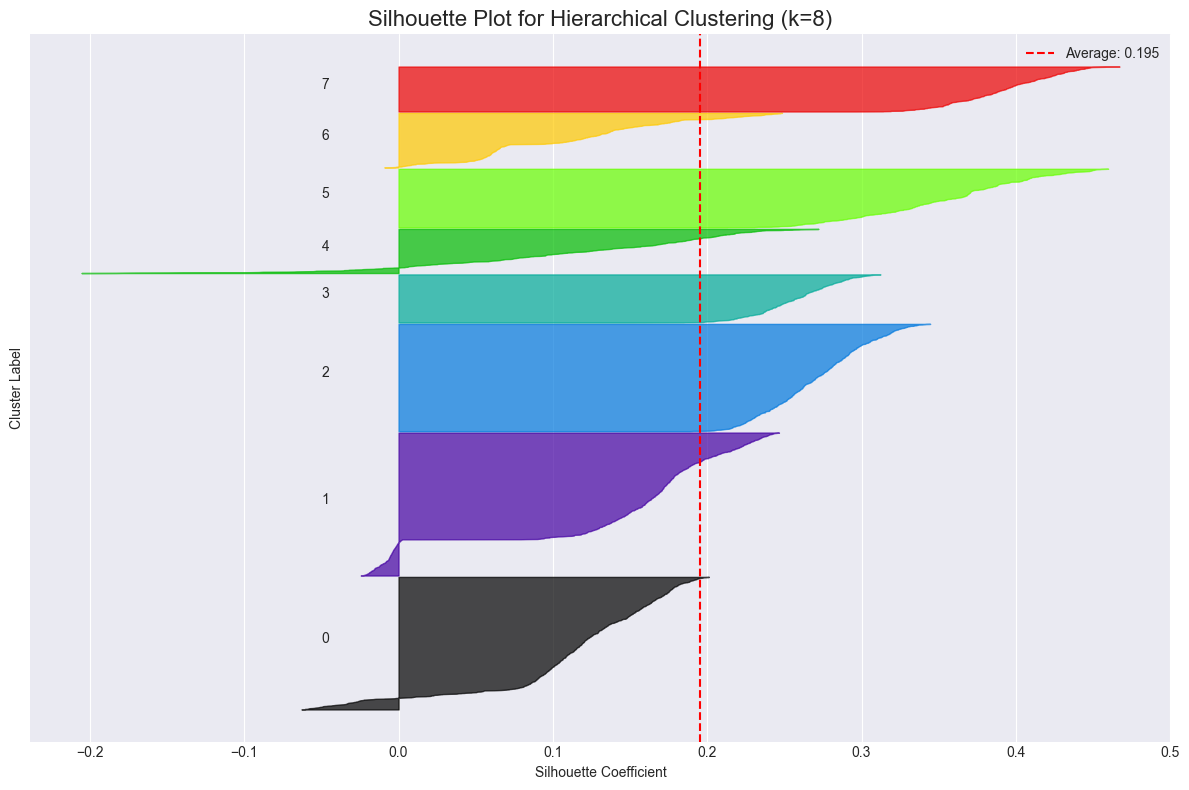

In [17]:
# # Compute silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(X, cluster_labels_sample)

# fig, ax = plt.subplots(figsize=(12, 8))

# y_lower = 10
# for i in range(optimal_k):
#     # Get silhouette scores for samples in cluster i
#     cluster_silhouette_values = sample_silhouette_values[cluster_labels_sample == i]
#     cluster_silhouette_values.sort()
    
#     size_cluster_i = cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i
    
#     color = plt.cm.nipy_spectral(float(i) / optimal_k)
#     ax.fill_betweenx(np.arange(y_lower, y_upper),
#                      0, cluster_silhouette_values,
#                      facecolor=color, edgecolor=color, alpha=0.7)
    
#     # Label clusters
#     ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#     y_lower = y_upper + 10

# ax.set_title(f'Silhouette Plot for Hierarchical Clustering (k={optimal_k})', fontsize=16)
# ax.set_xlabel('Silhouette Coefficient')
# ax.set_ylabel('Cluster Label')
# ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average: {silhouette_avg:.3f}')
# ax.legend()
# ax.set_yticks([])
# plt.tight_layout()
# plt.show()
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

# Compute silhouette scores for each SAMPLE
sample_silhouette_values = silhouette_samples(
    X_sample,
    cluster_labels_sample
)

fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for samples in cluster i
    cluster_silhouette_values = sample_silhouette_values[
        cluster_labels_sample == i
    ]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    
    # Label clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title(
    f"Silhouette Plot for Hierarchical Clustering (k={optimal_k})",
    fontsize=16
)
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")

ax.axvline(
    x=silhouette_avg,
    color="red",
    linestyle="--",
    label=f"Average: {silhouette_avg:.3f}"
)

ax.legend()
ax.set_yticks([])
plt.tight_layout()
plt.show()


## 7. Visualize Clusters (PCA)

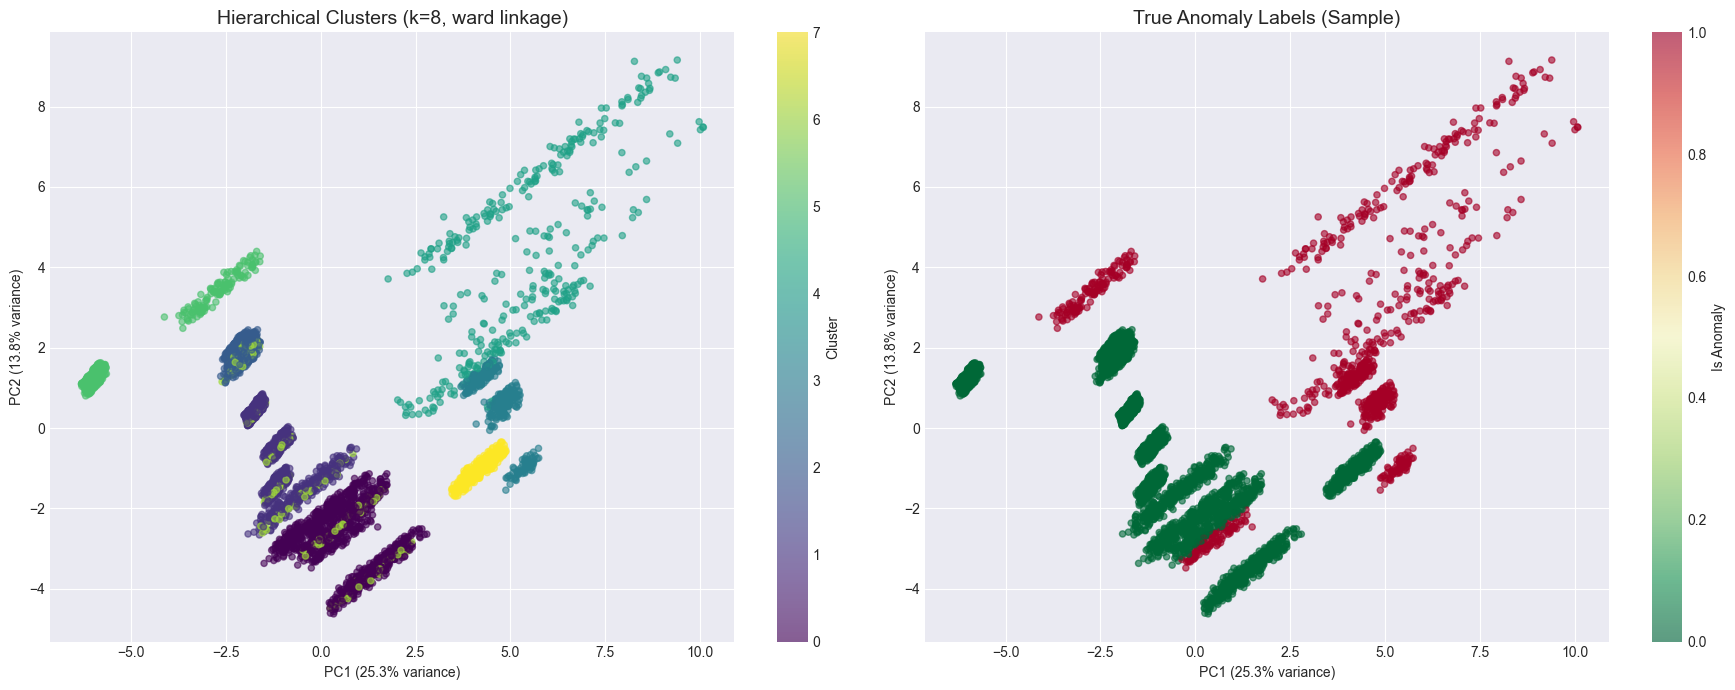

In [19]:
# # Reduce to 2D for visualization
# pca = PCA(n_components=2, random_state=42)
# X_pca = pca.fit_transform(X)

# fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# # Plot clusters
# scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
#                            c=cluster_labels_sample, cmap='viridis', 
#                            alpha=0.6, s=20, edgecolors='w', linewidth=0.5)
# axes[0].set_title(f'Hierarchical Clusters (k={optimal_k}, {linkage_method} linkage)', fontsize=14)
# axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
# axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
# plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# # Plot true anomaly labels if available
# if 'is_anomaly' in metadata.columns:
#     scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
#                                c=metadata['is_anomaly'], cmap='RdYlGn_r', 
#                                alpha=0.6, s=20, edgecolors='w', linewidth=0.5)
#     axes[1].set_title('True Anomaly Labels', fontsize=14)
#     axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
#     axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
#     plt.colorbar(scatter2, ax=axes[1], label='Is Anomaly')

# plt.tight_layout()
# plt.show()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ------------------------------------------------
# PCA on SAMPLE data only (IMPORTANT)
# ------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_sample_pca = pca.fit_transform(X_sample)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# -------------------------------
# Plot hierarchical clusters
# -------------------------------
scatter1 = axes[0].scatter(
    X_sample_pca[:, 0],
    X_sample_pca[:, 1],
    c=cluster_labels_sample,
    cmap='viridis',
    alpha=0.6,
    s=20
)

axes[0].set_title(
    f'Hierarchical Clusters (k={optimal_k}, {linkage_method} linkage)',
    fontsize=14
)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# --------------------------------
# Plot true anomaly labels (sample)
# --------------------------------
if 'is_anomaly' in metadata.columns:
    metadata_sample = metadata.iloc[sample_indices]

    scatter2 = axes[1].scatter(
        X_sample_pca[:, 0],
        X_sample_pca[:, 1],
        c=metadata_sample['is_anomaly'],
        cmap='RdYlGn_r',
        alpha=0.6,
        s=20
    )

    axes[1].set_title('True Anomaly Labels (Sample)', fontsize=14)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.colorbar(scatter2, ax=axes[1], label='Is Anomaly')

plt.tight_layout()
plt.show()


## 8. Cluster Characteristics Analysis

Hierarchical clustering completed in 2.57 seconds
Cluster distribution:
0    1046
1    1128
2     847
3     380
4     349
5     464
6     431
7     355
Name: count, dtype: int64
HIERARCHICAL CLUSTERING EVALUATION METRICS (SAMPLE)
Number of clusters: 8
Linkage method: ward
Training time: 2.57 seconds
  - Silhouette Score: 0.1954 (higher is better)
  - Davies-Bouldin Index: 1.7243 (lower is better)
  - Calinski-Harabasz Score: 766.63 (higher is better)


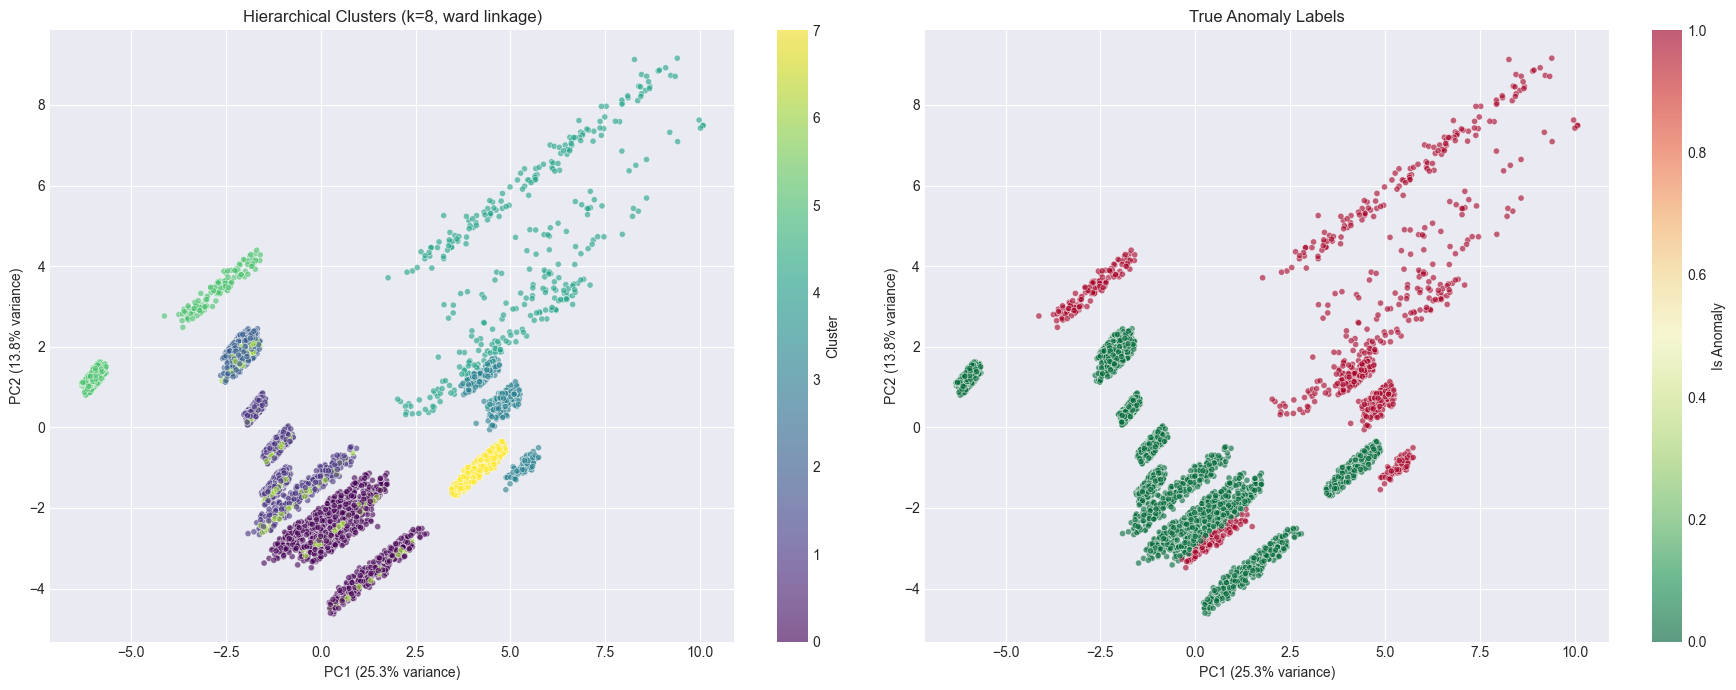

CLUSTER CHARACTERISTICS

Cluster 0:
  Size: 1,046 (20.9%)
  Anomaly rate: 10.13%
  Top services:
service
user-service         180
analytics-service    174
payment-service      167
Name: count, dtype: int64
  Top panels:
panel
Connection Pool Usage    344
JVM Heap Usage           312
Memory Usage             284
Name: count, dtype: int64

Cluster 1:
  Size: 1,128 (22.6%)
  Anomaly rate: 0.00%
  Top services:
service
analytics-service    201
payment-service      198
api-gateway          194
Name: count, dtype: int64
  Top panels:
panel
GC Time           289
Query Duration    286
CPU Usage         280
Name: count, dtype: int64

Cluster 2:
  Size: 847 (16.9%)
  Anomaly rate: 0.00%
  Top services:
service
notification-service    165
user-service            154
analytics-service       144
Name: count, dtype: int64
  Top panels:
panel
Response Time P99    303
Response Time P95    288
Request Rate         256
Name: count, dtype: int64

Cluster 3:
  Size: 380 (7.6%)
  Anomaly rate: 100.00%
  To

In [23]:
# # Add cluster labels to metadata
# metadata['hierarchical_cluster'] = cluster_labels_sample

# # Analyze clusters
# print("CLUSTER CHARACTERISTICS")
# print("="*80)

# for cluster_id in range(optimal_k):
#     cluster_mask = metadata['hierarchical_cluster'] == cluster_id
#     cluster_data = metadata[cluster_mask]
    
#     print(f"\nCluster {cluster_id}:")
#     print(f"  Size: {len(cluster_data):,} ({len(cluster_data)/len(metadata)*100:.1f}%)")
    
#     if 'is_anomaly' in metadata.columns:
#         anomaly_rate = cluster_data['is_anomaly'].mean() * 100
#         print(f"  Anomaly rate: {anomaly_rate:.2f}%")
    
#     print(f"  Top services:")
#     print(cluster_data['service'].value_counts().head(3))
    
#     print(f"  Top panels:")
#     print(cluster_data['panel'].value_counts().head(3))
# =========================
# 0️⃣ Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (silhouette_score, silhouette_samples,
                             davies_bouldin_score, calinski_harabasz_score)
from sklearn.decomposition import PCA
import time

# =========================
# 1️⃣ Sample the data for hierarchical clustering
# =========================
n_sample = 5000  # adjust based on memory
np.random.seed(42)

# Sample row indices
sample_indices = np.random.choice(X.shape[0], n_sample, replace=False)

# Sample features (use .iloc for row selection, convert to numpy array)
X_sampled = X.iloc[sample_indices].values

# Sample metadata for analysis
metadata_sample = metadata.iloc[sample_indices].copy()

# =========================
# 2️⃣ Hierarchical clustering
# =========================
optimal_k = optimal_k_silhouette  # previously computed
linkage_method = 'ward'           # example

start_time = time.time()
agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage=linkage_method)
cluster_labels_sample = agg_final.fit_predict(X_sampled)
training_time = time.time() - start_time

print(f"Hierarchical clustering completed in {training_time:.2f} seconds")
print("Cluster distribution:")
print(pd.Series(cluster_labels_sample).value_counts().sort_index())

# Attach cluster labels to metadata
metadata_sample['hierarchical_cluster'] = cluster_labels_sample

# =========================
# 3️⃣ Internal validation metrics
# =========================
silhouette_avg = silhouette_score(X_sampled, cluster_labels_sample)
davies_bouldin = davies_bouldin_score(X_sampled, cluster_labels_sample)
calinski_harabasz = calinski_harabasz_score(X_sampled, cluster_labels_sample)

print("="*80)
print("HIERARCHICAL CLUSTERING EVALUATION METRICS (SAMPLE)")
print("="*80)
print(f"Number of clusters: {optimal_k}")
print(f"Linkage method: {linkage_method}")
print(f"Training time: {training_time:.2f} seconds")
print(f"  - Silhouette Score: {silhouette_avg:.4f} (higher is better)")
print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")

# =========================
# 4️⃣ PCA for 2D visualization
# =========================
pca = PCA(n_components=2, random_state=42)
X_pca_sample = pca.fit_transform(X_sampled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot hierarchical clusters
scatter1 = axes[0].scatter(
    X_pca_sample[:, 0],
    X_pca_sample[:, 1],
    c=cluster_labels_sample,
    cmap='viridis',
    alpha=0.6,
    s=20,
    edgecolors='w',
    linewidth=0.5
)
axes[0].set_title(f'Hierarchical Clusters (k={optimal_k}, {linkage_method} linkage)')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot true anomaly labels if available
if 'is_anomaly' in metadata.columns:
    scatter2 = axes[1].scatter(
        X_pca_sample[:, 0],
        X_pca_sample[:, 1],
        c=metadata_sample['is_anomaly'],
        cmap='RdYlGn_r',
        alpha=0.6,
        s=20,
        edgecolors='w',
        linewidth=0.5
    )
    axes[1].set_title('True Anomaly Labels')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.colorbar(scatter2, ax=axes[1], label='Is Anomaly')

plt.tight_layout()
plt.show()

# =========================
# 5️⃣ Analyze cluster characteristics
# =========================
print("CLUSTER CHARACTERISTICS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_data = metadata_sample[metadata_sample['hierarchical_cluster'] == cluster_id]

    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data):,} ({len(cluster_data)/len(metadata_sample)*100:.1f}%)")

    if 'is_anomaly' in metadata_sample.columns:
        anomaly_rate = cluster_data['is_anomaly'].mean() * 100
        print(f"  Anomaly rate: {anomaly_rate:.2f}%")

    print("  Top services:")
    print(cluster_data['service'].value_counts().head(3))

    print("  Top panels:")
    print(cluster_data['panel'].value_counts().head(3))


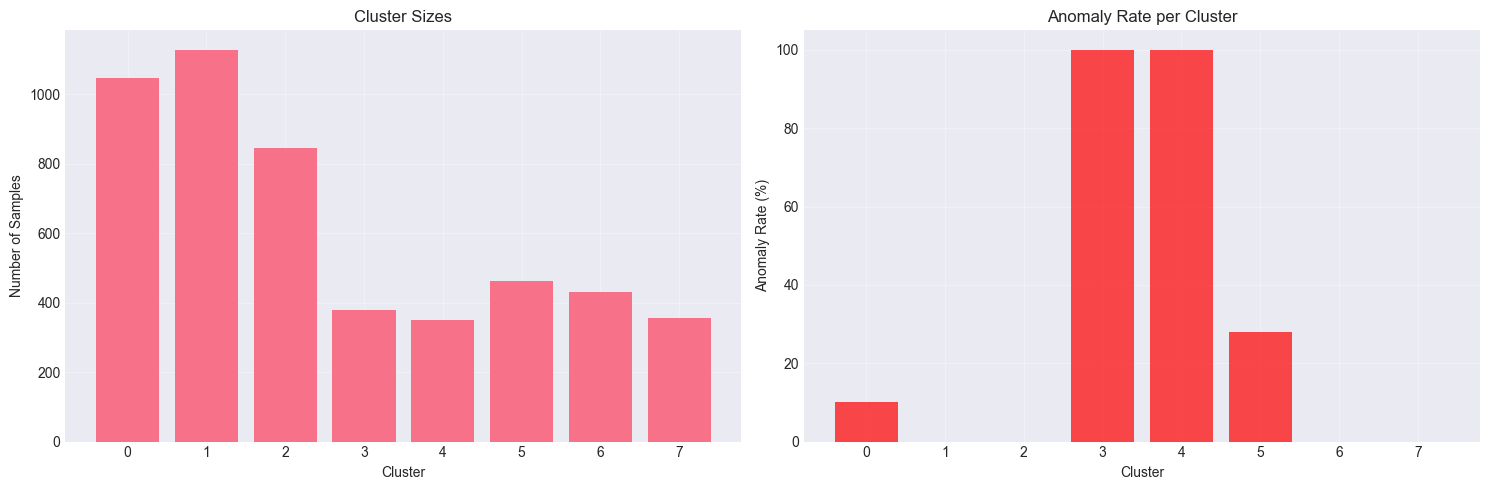

In [25]:
# # Visualize cluster characteristics
# if 'is_anomaly' in metadata.columns:
#     # Anomaly distribution per cluster
#     cluster_anomaly = metadata.groupby('hierarchical_cluster')['is_anomaly'].agg(['sum', 'count', 'mean'])
#     cluster_anomaly['anomaly_rate'] = cluster_anomaly['mean'] * 100
    
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Cluster sizes
#     axes[0].bar(range(optimal_k), cluster_anomaly['count'])
#     axes[0].set_xlabel('Cluster')
#     axes[0].set_ylabel('Number of Samples')
#     axes[0].set_title('Cluster Sizes')
#     axes[0].grid(True, alpha=0.3)
    
#     # Anomaly rates
#     axes[1].bar(range(optimal_k), cluster_anomaly['anomaly_rate'], color='red', alpha=0.7)
#     axes[1].set_xlabel('Cluster')
#     axes[1].set_ylabel('Anomaly Rate (%)')
#     axes[1].set_title('Anomaly Rate per Cluster')
#     axes[1].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()
# Visualize cluster characteristics (sampled clusters)
if 'is_anomaly' in metadata_sample.columns:
    # Anomaly distribution per cluster
    cluster_anomaly = metadata_sample.groupby('hierarchical_cluster')['is_anomaly'].agg(['sum', 'count', 'mean'])
    cluster_anomaly['anomaly_rate'] = cluster_anomaly['mean'] * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Cluster sizes
    axes[0].bar(cluster_anomaly.index, cluster_anomaly['count'])
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Cluster Sizes')
    axes[0].grid(True, alpha=0.3)
    
    # Anomaly rates
    axes[1].bar(cluster_anomaly.index, cluster_anomaly['anomaly_rate'], color='red', alpha=0.7)
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Anomaly Rate (%)')
    axes[1].set_title('Anomaly Rate per Cluster')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 9. Compare Different Linkage Methods

In [27]:
# # Compare different linkage methods with optimal k
# linkage_methods = ['ward', 'complete', 'average', 'single']
# linkage_comparison = []

# print(f"Comparing linkage methods with k={optimal_k}...\n")

# for method in linkage_methods:
#     print(f"Testing {method} linkage...", end=' ')
#     start_time = time.time()
    
#     agg = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
#     labels = agg.fit_predict(X)
    
#     train_time = time.time() - start_time
    
#     metrics = {
#         'linkage': method,
#         'silhouette': silhouette_score(X, labels),
#         'davies_bouldin': davies_bouldin_score(X, labels),
#         'calinski_harabasz': calinski_harabasz_score(X, labels),
#         'time': train_time
#     }
    
#     if 'is_anomaly' in metadata.columns:
#         metrics['ari'] = adjusted_rand_score(metadata['is_anomaly'], labels)
#         metrics['nmi'] = normalized_mutual_info_score(metadata['is_anomaly'], labels)
    
#     linkage_comparison.append(metrics)
#     print(f"Silhouette: {metrics['silhouette']:.3f}, Time: {train_time:.2f}s")

# linkage_df = pd.DataFrame(linkage_comparison)
# print("\nLinkage Method Comparison:")
# print(linkage_df.to_string(index=False))
# Compare different linkage methods using the sampled data
linkage_methods = ['ward', 'complete', 'average', 'single']
linkage_comparison = []

print(f"Comparing linkage methods with k={optimal_k} on sampled data...\n")

for method in linkage_methods:
    print(f"Testing {method} linkage...", end=' ')
    start_time = time.time()
    
    agg = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    labels = agg.fit_predict(X_sampled)  # ⚡ Use sampled data
    
    train_time = time.time() - start_time
    
    metrics = {
        'linkage': method,
        'silhouette': silhouette_score(X_sampled, labels),
        'davies_bouldin': davies_bouldin_score(X_sampled, labels),
        'calinski_harabasz': calinski_harabasz_score(X_sampled, labels),
        'time': train_time
    }
    
    # External validation metrics (if true labels exist in sample)
    if 'is_anomaly' in metadata_sample.columns:
        metrics['ari'] = adjusted_rand_score(metadata_sample['is_anomaly'], labels)
        metrics['nmi'] = normalized_mutual_info_score(metadata_sample['is_anomaly'], labels)
    
    linkage_comparison.append(metrics)
    print(f"Silhouette: {metrics['silhouette']:.3f}, Time: {train_time:.2f}s")

# Display results
linkage_df = pd.DataFrame(linkage_comparison)
print("\nLinkage Method Comparison (Sampled Data):")
print(linkage_df.to_string(index=False))


Comparing linkage methods with k=8 on sampled data...

Testing ward linkage... Silhouette: 0.195, Time: 3.15s
Testing complete linkage... Silhouette: 0.189, Time: 2.11s
Testing average linkage... Silhouette: 0.190, Time: 2.62s
Testing single linkage... Silhouette: 0.106, Time: 1.90s

Linkage Method Comparison (Sampled Data):
 linkage  silhouette  davies_bouldin  calinski_harabasz     time      ari      nmi
    ward    0.195386        1.724349         766.629459 3.147112 0.116879 0.298778
complete    0.188601        1.595812         498.051446 2.112573 0.310373 0.262199
 average    0.190494        1.339058         423.645757 2.616322 0.534287 0.421736
  single    0.106109        1.000856         182.075554 1.903211 0.061551 0.093631


## 10. Save Results

In [29]:
# # Save cluster labels
# metadata.to_csv('../data/hierarchical_results.csv', index=False)
# print("Hierarchical clustering results saved!")

# # Save metrics
# metrics = {
#     'algorithm': 'Hierarchical',
#     'linkage': linkage_method,
#     'n_clusters': optimal_k,
#     'training_time': training_time,
#     'silhouette_score': silhouette_avg,
#     'davies_bouldin_index': davies_bouldin,
#     'calinski_harabasz_score': calinski_harabasz
# }

# if 'is_anomaly' in metadata.columns:
#     metrics.update({
#         'adjusted_rand_index': ari,
#         'normalized_mutual_info': nmi,
#         'homogeneity': homogeneity,
#         'completeness': completeness,
#         'v_measure': v_measure
#     })

# metrics_df = pd.DataFrame([metrics])
# metrics_df.to_csv('../data/hierarchical_metrics.csv', index=False)
# print("Hierarchical clustering metrics saved!")

# # Save linkage comparison
# linkage_df.to_csv('../data/hierarchical_linkage_comparison.csv', index=False)
# print("Linkage comparison saved!")

# print("\nHierarchical clustering complete!")
# Save sampled cluster labels
metadata_sample.to_csv('../data/hierarchical_results_sample.csv', index=False)
print("Hierarchical clustering results (sample) saved!")

# Compute metrics for sampled clustering
silhouette_avg = silhouette_score(X_sampled, cluster_labels_sample)
davies_bouldin = davies_bouldin_score(X_sampled, cluster_labels_sample)
calinski_harabasz = calinski_harabasz_score(X_sampled, cluster_labels_sample)

metrics = {
    'algorithm': 'Hierarchical',
    'linkage': linkage_method,
    'n_clusters': optimal_k,
    'training_time': training_time,
    'silhouette_score': silhouette_avg,
    'davies_bouldin_index': davies_bouldin,
    'calinski_harabasz_score': calinski_harabasz
}

# External metrics if anomaly labels exist in sample
if 'is_anomaly' in metadata_sample.columns:
    ari = adjusted_rand_score(metadata_sample['is_anomaly'], cluster_labels_sample)
    nmi = normalized_mutual_info_score(metadata_sample['is_anomaly'], cluster_labels_sample)
    homogeneity = homogeneity_score(metadata_sample['is_anomaly'], cluster_labels_sample)
    completeness = completeness_score(metadata_sample['is_anomaly'], cluster_labels_sample)
    v_measure = v_measure_score(metadata_sample['is_anomaly'], cluster_labels_sample)
    
    metrics.update({
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure
    })

# Save metrics
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../data/hierarchical_metrics_sample.csv', index=False)
print("Hierarchical clustering metrics (sample) saved!")

# Save linkage comparison
linkage_df.to_csv('../data/hierarchical_linkage_comparison_sample.csv', index=False)
print("Linkage comparison (sample) saved!")

print("\nHierarchical clustering complete on sampled data!")


Hierarchical clustering results (sample) saved!
Hierarchical clustering metrics (sample) saved!
Linkage comparison (sample) saved!

Hierarchical clustering complete on sampled data!
